## Get Data

In [61]:
from sklearn.datasets import fetch_olivetti_faces

data = fetch_olivetti_faces()
import numpy as np

Let's get to know the data by exploring the type and viewing some of the methods built in.

In [62]:
type(data)

sklearn.utils.Bunch

In [63]:
help(data)

Help on Bunch in module sklearn.utils object:

class Bunch(builtins.dict)
 |  Bunch(**kwargs)
 |  
 |  Container object exposing keys as attributes.
 |  
 |  Bunch objects are sometimes used as an output for functions and methods.
 |  They extend dictionaries by enabling values to be accessed by key,
 |  `bunch["value_key"]`, or by an attribute, `bunch.value_key`.
 |  
 |  Examples
 |  --------
 |  >>> from sklearn.utils import Bunch
 |  >>> b = Bunch(a=1, b=2)
 |  >>> b['b']
 |  2
 |  >>> b.b
 |  2
 |  >>> b.a = 3
 |  >>> b['a']
 |  3
 |  >>> b.c = 6
 |  >>> b['c']
 |  6
 |  
 |  Method resolution order:
 |      Bunch
 |      builtins.dict
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __dir__(self)
 |      Default dir() implementation.
 |  
 |  __getattr__(self, key)
 |  
 |  __init__(self, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __setattr__(self, key, value)
 |      Implement setattr(self, name, value).
 |  
 |  __se

In [64]:
data.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [65]:
data['data'].shape

(400, 4096)

In [66]:
data['target'].shape

(400,)

What are the target variables?

In [67]:
type(data['target'])

numpy.ndarray

In [68]:
np.unique(data['target'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

Ok there are 400 different data points and 40 different target values. My assumption is that each target has 10 data points. Let's see if that is true.

In [69]:
values, counts = np.unique(data['target'], return_counts = True)
for val, count in zip(values, counts):
    print(val, count)

0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10
10 10
11 10
12 10
13 10
14 10
15 10
16 10
17 10
18 10
19 10
20 10
21 10
22 10
23 10
24 10
25 10
26 10
27 10
28 10
29 10
30 10
31 10
32 10
33 10
34 10
35 10
36 10
37 10
38 10
39 10


Looks like the assumption was correct. We need to worry about splitting the data in a strified fashion. Reading the documentation for [train_test_split](#https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn) shows that we can stratify using the stratify attribute.

## Split Data

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], train_size = 0.7, stratify = data['target'])

Let's make sure the class balance is similar accross the two datasets.

In [87]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.ticker as mtick


def plot_target_distributions(y_dict):
    ind = 0
    fig, axs = plt.subplots(2,1)
    fig.set_size_inches(10,10)

    for y_key, y_values in y_dict.items():
        y_targets, y_counts = np.unique(y_values, return_counts = True)
        n = y_values.shape[0]
        y_counts = y_counts / n
        if ind == 0:
            color = '#006272'
        else:
            color = '#003366'

        df_ = pd.DataFrame(data = {'targets' : y_targets, 'counts' : y_counts})
        sns.barplot(data = df_, x = 'targets', y = 'counts', ax = axs[ind], color = color)
        axs[ind].get_yaxis().set_visible(False)
        axs[ind].title.set_text('Target Distribution for {}'.format(y_key))

        ind += 1
    plt.tight_layout()
    plt.show()

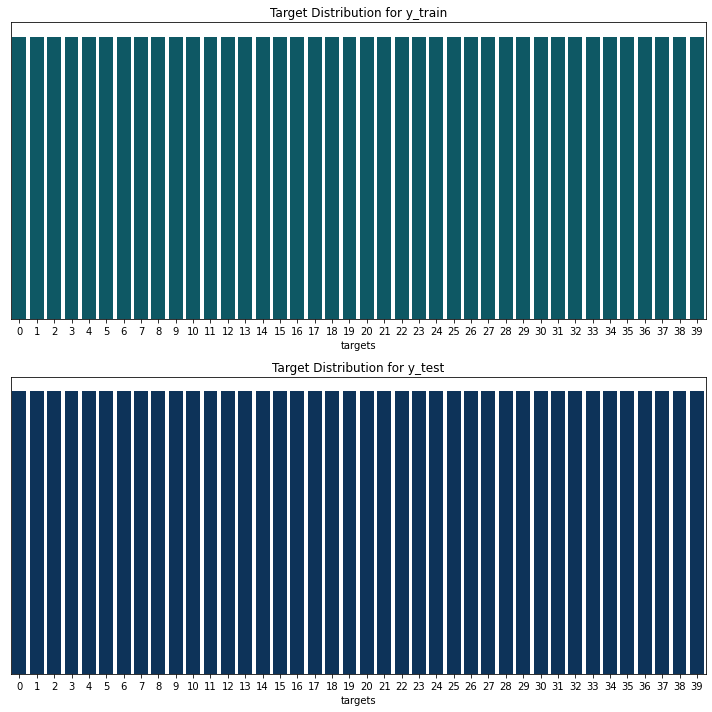

In [88]:
plot_target_distributions({'y_train' : y_train, 'y_test' : y_test})

Above we can see that the each class represents 2.5% of the data in the training and testing set. This confirms that the classes are evenly distributed among the training and testing sets.

## Visualize 25 Faces

From the description of the assignment, we know that the images are flattened but are supposed to be 64 by 64. Let's visualize the first image, then 25 at once.

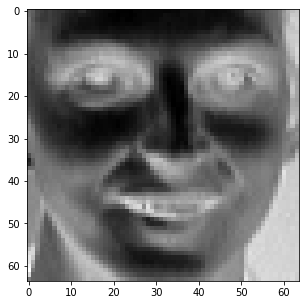

In [73]:
fig, axs = plt.subplots(1,1)
fig.set_size_inches(5,5)

sample = X_train[0].reshape(64, 64)

plt.imshow(sample, cmap = mpl.cm.binary)
plt.show()

Now let's try to make a 5 by 5 grid of the first 25 faces.

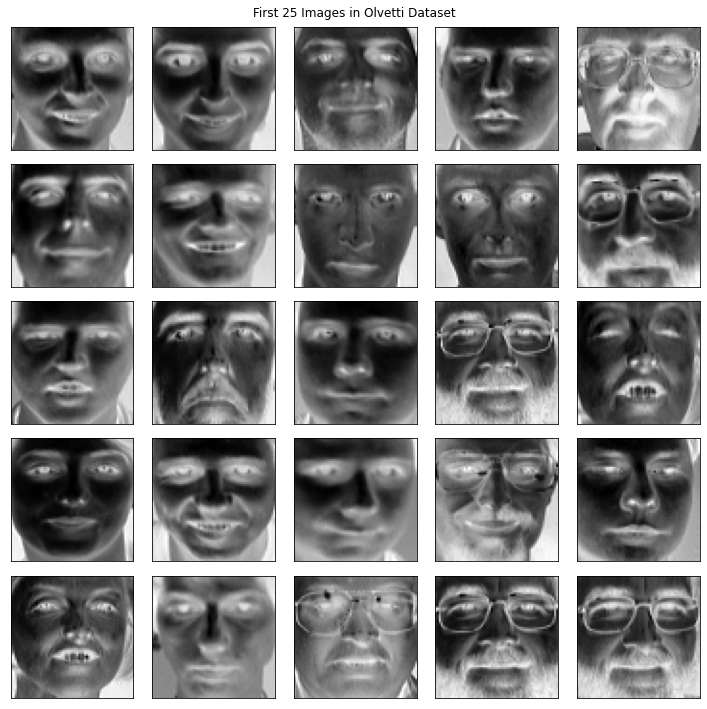

In [74]:
fig, axs = plt.subplots(5,5)

fig.set_size_inches(10,10)

axs = axs.ravel()
for ind in range(25):
    axs[ind].imshow(X_train[ind].reshape(64,64), cmap = mpl.cm.binary)
    axs[ind].set_xticks([])
    axs[ind].set_yticks([])

fig.suptitle('First 25 Images in Olvetti Dataset')
fig.tight_layout()
plt.show()

Looks like some of the faces are the same person from a different angle. My hypothesis is that the clusters will find people that have the similar expressions, or each cluster will be for each person.

## Clustering

We will use k-means clustering in this dataset. To find the optimal number of clusters, we will train a model with 2-40 clusters. I will choose the cluster that has based on the elbow analysis score, and then we can see how it clusters the test set.

In [95]:
from sklearn.cluster import KMeans
from datetime import datetime

def train_clusters(data, target, n_clusters = 40):

    # set up dict to save cluster
    cluster_dict = {}

    for cluster_ind in range(2, n_clusters + 1):
        cluster_name = 'Cluster_{}'.format(cluster_ind)

        # timer
        start = datetime.now()
        print('================================================\n')
        print('Begining clustering for {} -- {}'.format(cluster_name, start))
        # training
        cluster_dict[cluster_name] = KMeans(n_clusters = cluster_ind, random_state = 8, n_init = 100, max_iter = 500).fit(data, target)
        end = datetime.now()
        print('{} completed -- {}'.format(cluster_name, end))
        print('Time elapsed : {}\n'.format(end - start))
        print('================================================')

    return cluster_dict

In [96]:
cluster_dict = train_clusters(X_train, y_train)


Begining clustering for Cluster_2 -- 2022-02-16 19:59:30.501601
Cluster_2 completed -- 2022-02-16 19:59:32.215165
Time elapsed : 0:00:01.713564


Begining clustering for Cluster_3 -- 2022-02-16 19:59:32.215165
Cluster_3 completed -- 2022-02-16 19:59:34.598379
Time elapsed : 0:00:02.383214


Begining clustering for Cluster_4 -- 2022-02-16 19:59:34.598379
Cluster_4 completed -- 2022-02-16 19:59:37.356123
Time elapsed : 0:00:02.757744


Begining clustering for Cluster_5 -- 2022-02-16 19:59:37.356123
Cluster_5 completed -- 2022-02-16 19:59:40.478023
Time elapsed : 0:00:03.121900


Begining clustering for Cluster_6 -- 2022-02-16 19:59:40.478023
Cluster_6 completed -- 2022-02-16 19:59:44.074149
Time elapsed : 0:00:03.596126


Begining clustering for Cluster_7 -- 2022-02-16 19:59:44.074149
Cluster_7 completed -- 2022-02-16 19:59:48.153939
Time elapsed : 0:00:04.079790


Begining clustering for Cluster_8 -- 2022-02-16 19:59:48.153939
Cluster_8 completed -- 2022-02-16 19:59:52.657471
Time elap